# btvNano Analysis - Jet Analysis

Analysis using `UPROOT` in python of btvNano samples created using btvNano customisations by [PFNano Production](https://github.com/cms-jet/PFNano/tree/106x).

In [1]:
import ROOT as rt
import uproot as uprt
import mplhep as mh
import matplotlib.pyplot as plt
import awkward as ak
import numpy as np

In [23]:
# Defining the style for plots (CMS Style)
plt.style.use(mh.style.CMS)
plt.rcParams.update({
    "font.size": 17,
    "axes.labelsize": 17,
    "axes.titlesize": 17,
    "xtick.labelsize": 17,
    "ytick.labelsize": 17,
    "legend.fontsize": 17
})

# Defining the function for making histograms
def make_hist(data, bins, range, xlabel, ylabel, label, fname=None, logy=False):
    histo, edges = np.histogram(data, bins=bins, range=range)
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    mh.histplot(histo, edges, histtype="step", label=label, ax=ax)
    mh.cms.label("Open Data", data=True, lumi=None, com=13, year=2016, loc=0)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    if logy:
        ax.set_yscale("log")
    if fname:
        plt.savefig(fname)
    plt.show()


In [3]:
# Loading the ROOT file

btvNanoFile = uprt.open("datasets/nano106X_on_mini106X_2017_mc_NANOAOD_TTToSemiLeptonic.root")
btvNanoEvents = btvNanoFile["Events"]

In [4]:
# We are interested in the RecoJets collections
RecoJet_keys = btvNanoEvents.keys(filter_name="Jet_*")
for RecoJets in btvNanoEvents.iterate(RecoJet_keys, step_size=btvNanoEvents.num_entries, library="ak"):
    break
# RecoJets

In [5]:
# We are also interested in the GenJets collections
GenJet_keys = btvNanoEvents.keys(filter_name="GenJet_*")
for GenJets in btvNanoEvents.iterate(GenJet_keys, step_size=btvNanoEvents.num_entries, library="ak"):
    break
# GenJets

## Truth matching - using $\delta R$ matching

In [6]:
n_events = len(RecoJets["Jet_pt"])
GoodJets = []

for evt in range(n_events):
    reco_pt = RecoJets["Jet_pt"][evt]
    reco_eta = RecoJets["Jet_eta"][evt]
    reco_phi = RecoJets["Jet_phi"][evt]
    reco_mass = RecoJets["Jet_mass"][evt]

    gen_pt = GenJets["GenJet_pt"][evt]
    gen_eta = GenJets["GenJet_eta"][evt]
    gen_phi = GenJets["GenJet_phi"][evt]
    gen_mass = GenJets["GenJet_mass"][evt]

    for i, (rpt, reta, rphi, rmass) in enumerate(zip(reco_pt, reco_eta, reco_phi, reco_mass)):
        reco_vec = rt.TLorentzVector()
        reco_vec.SetPtEtaPhiM(rpt, reta, rphi, rmass)
        min_dR = 999
        min_j = -1
        for j, (gpt, geta, gphi, gmass) in enumerate(zip(gen_pt, gen_eta, gen_phi, gen_mass)):
            gen_vec = rt.TLorentzVector()
            gen_vec.SetPtEtaPhiM(gpt, geta, gphi, gmass)
            dR = reco_vec.DeltaR(gen_vec)
            if dR < min_dR:
                min_dR = dR
                min_j = j
        GoodJets.append({
            "nEvents": evt,
            "Jet_pt": rpt,
            "Jet_eta": reta,
            "Jet_phi": rphi,
            "Jet_mass": rmass,
            "Jet_btagDeepB": RecoJets["Jet_btagDeepB"][evt][i],
            "Jet_btagDeepFlavB": RecoJets["Jet_btagDeepFlavB"][evt][i],
            "Jet_btagDeepCvL": RecoJets["Jet_btagDeepCvL"][evt][i],
            "Jet_btagDeepCvB": RecoJets["Jet_btagDeepCvB"][evt][i],
            "Jet_btagDeepFlavCvB": RecoJets["Jet_btagDeepFlavCvB"][evt][i],
            "Jet_btagDeepFlavCvL": RecoJets["Jet_btagDeepFlavCvL"][evt][i],
            "Jet_btagDeepFlavQG": RecoJets["Jet_btagDeepFlavQG"][evt][i],
            "Jet_btagDeepB_bb": RecoJets["Jet_btagDeepB_bb"][evt][i],
            "Jet_btagDeepB_b": RecoJets["Jet_btagDeepB_b"][evt][i],
            "Jet_btagCSVV2": RecoJets["Jet_btagCSVV2"][evt][i],
            "matched_GenJetIdx": min_j,
            "min_dR": min_dR
        })

GoodJets = ak.Array(GoodJets)

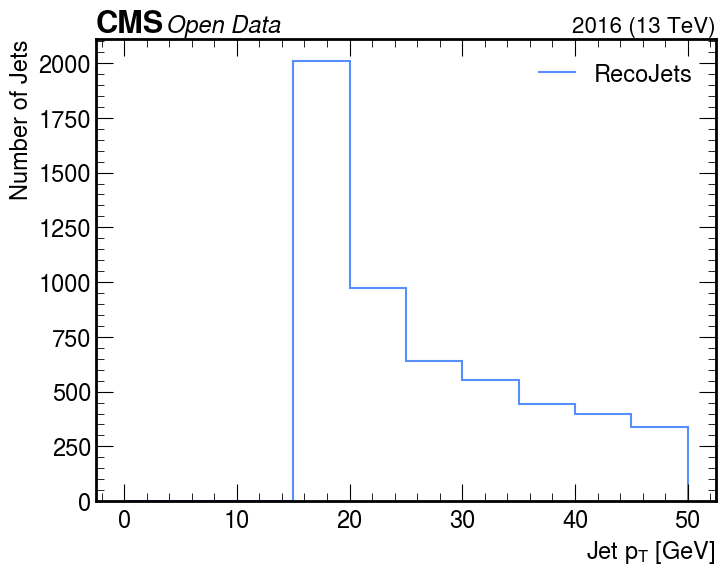

In [24]:
RecoJet_pT = ak.to_numpy(ak.flatten(RecoJets["Jet_pt"]))

make_hist(
    RecoJet_pT,
    bins=10,
    range=(0, 50),
    xlabel="Jet $p_{T}$ [GeV]",
    ylabel="Number of Jets",
    label="RecoJets",
    fname="plots/RecoJet_pT.png",
    logy=False
)

In [37]:
RecoJet_btagCSVV2 = ak.to_numpy(ak.flatten(RecoJets["Jet_btagCSVV2"]))
RecoJet_btagDeepB = ak.to_numpy(ak.flatten(RecoJets["Jet_btagDeepB"]))
RecoJet_btagDeepB_b = ak.to_numpy(ak.flatten(RecoJets["Jet_btagDeepB_b"]))
RecoJet_btagDeepB_bb = ak.to_numpy(ak.flatten(RecoJets["Jet_btagDeepB_bb"]))
RecoJet_btagDeepCvB = ak.to_numpy(ak.flatten(RecoJets["Jet_btagDeepCvB"]))
RecoJet_btagDeepCvL = ak.to_numpy(ak.flatten(RecoJets["Jet_btagDeepCvL"]))
RecoJet_btagDeepFlavCvB = ak.to_numpy(ak.flatten(RecoJets["Jet_btagDeepFlavCvB"]))
RecoJet_btagDeepFlavCvL = ak.to_numpy(ak.flatten(RecoJets["Jet_btagDeepFlavCvL"]))
RecoJet_btagDeepFlavQG = ak.to_numpy(ak.flatten(RecoJets["Jet_btagDeepFlavQG"]))
RecoJet_btagDeepFlavB = ak.to_numpy(ak.flatten(RecoJets["Jet_btagDeepFlavB"]))
RecoJet_btagDeepL = ak.to_numpy(ak.flatten(RecoJets["Jet_btagDeepL"]))
RecoJet_hadronFlavour = ak.to_numpy(ak.flatten(RecoJets["Jet_hadronFlavour"]))
GenJet_hadronFlavour = ak.to_numpy(ak.flatten(GenJets["GenJet_hadronFlavour"]))
RecoJet_nBHadrons = ak.to_numpy(ak.flatten(RecoJets["Jet_nBHadrons"]))
RecoJet_nCHadrons = ak.to_numpy(ak.flatten(RecoJets["Jet_nCHadrons"]))

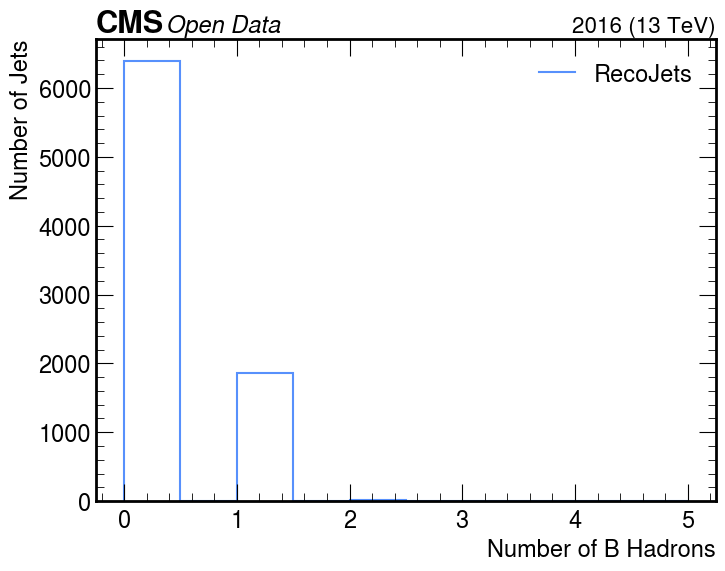

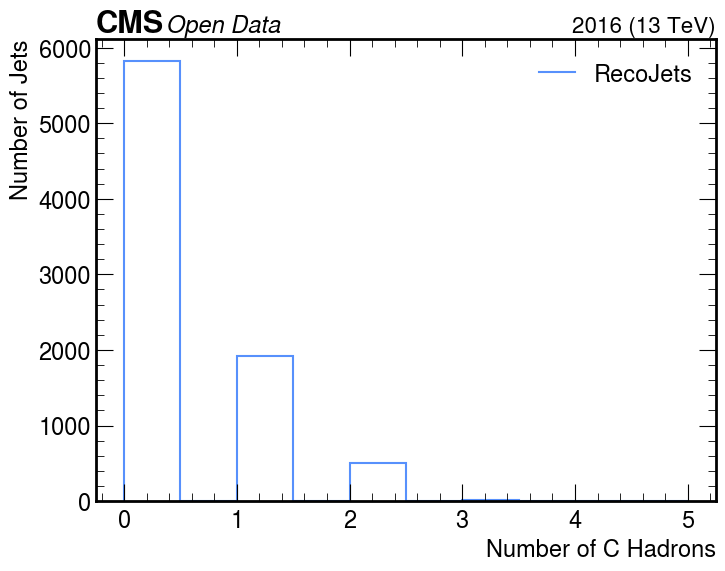

In [43]:
make_hist(
    RecoJet_nBHadrons,
    bins=10,
    range=(0, 5),
    xlabel="Number of B Hadrons",
    ylabel="Number of Jets",
    label="RecoJets",
    fname="plots/RecoJet_nBHadrons.png",
    logy=False
)

make_hist(
    RecoJet_nCHadrons,
    bins=10,
    range=(0, 5),
    xlabel="Number of C Hadrons",
    ylabel="Number of Jets",
    label="RecoJets",
    fname="plots/RecoJet_nCHadrons.png",
    logy=False
)

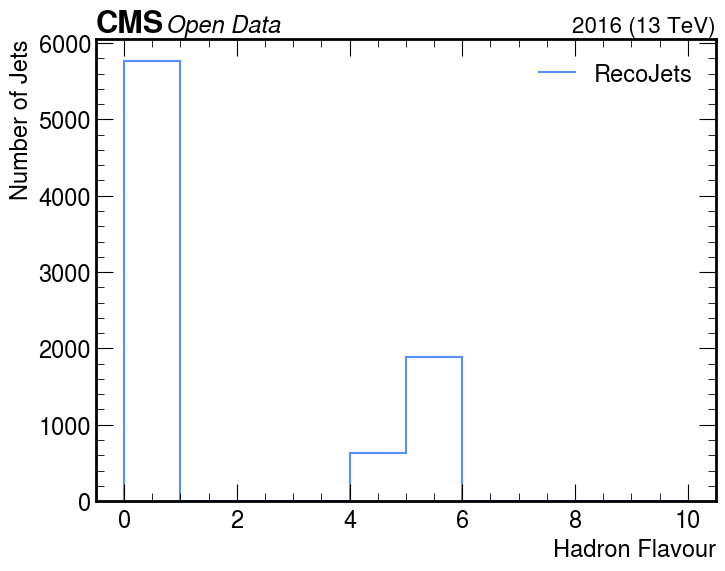

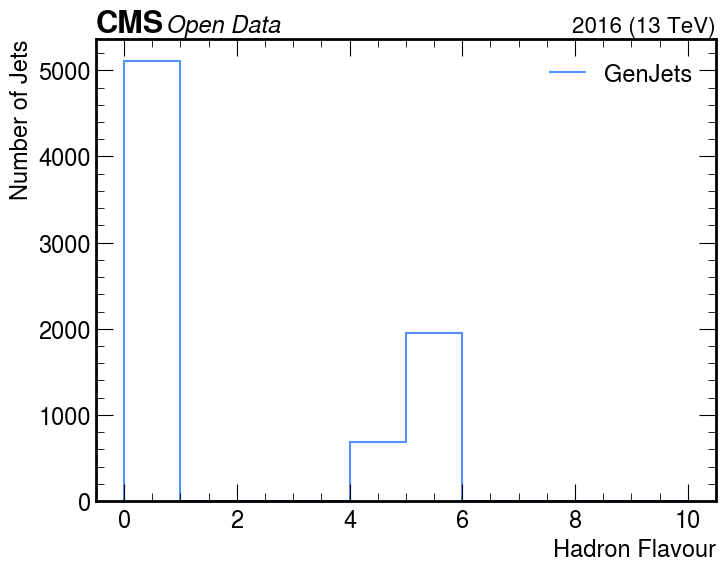

In [25]:
make_hist(
    data=RecoJet_hadronFlavour,
    bins=10,
    range=(0, 10),
    xlabel="Hadron Flavour",
    ylabel="Number of Jets",
    label="RecoJets",
    fname="plots/RecoJet_hadronFlavour.png",
    logy=False
)

make_hist(
    data=GenJet_hadronFlavour,
    bins=10,
    range=(0, 10),
    xlabel="Hadron Flavour",
    ylabel="Number of Jets",
    label="GenJets",
    fname="plots/GenJet_hadronFlavour.png",
    logy=False
)

In [26]:
def make_stack_hist(data, labels, bins, range, xlabel, ylabel, fname=None, logy=False):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    plt.hist(
        data,
        bins=bins,
        range=range,
        histtype="stepfilled",
        label=labels,
        density=True,
        stacked=True
    )

    mh.cms.label("Open Data", data=True, lumi=None, com=13, year=2016, loc=0)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    if logy:
        ax.set_yscale("log")
    if fname:
        plt.savefig(fname)
    plt.show()

In [10]:
# Create masks for each jet flavour using the flattened arrays
b_mask = RecoJet_hadronFlavour == 5
c_mask = RecoJet_hadronFlavour == 4
light_mask = RecoJet_hadronFlavour == 0

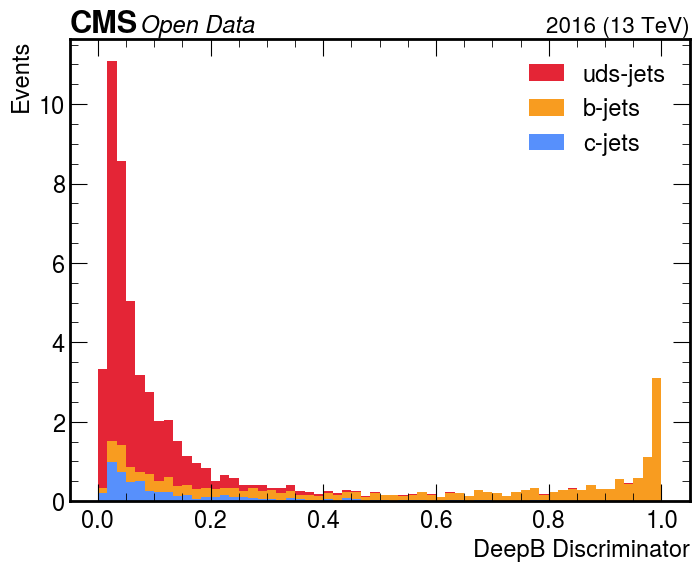

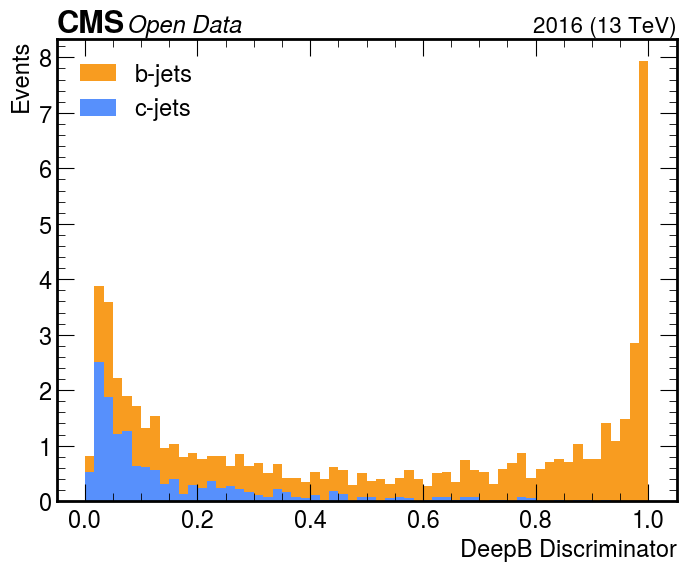

In [27]:
bjets_DeepB = RecoJet_btagDeepB[b_mask]
bjets_DeepB = bjets_DeepB[bjets_DeepB != -1]
cjets_DeepB = RecoJet_btagDeepB[c_mask]
cjets_DeepB = cjets_DeepB[cjets_DeepB != -1]
lightjets_DeepB = RecoJet_btagDeepB[light_mask]
lightjets_DeepB = lightjets_DeepB[lightjets_DeepB != -1]

data = [cjets_DeepB, bjets_DeepB, lightjets_DeepB]
labels = ["c-jets", "b-jets", "uds-jets"]

data_BvC = [cjets_DeepB, bjets_DeepB]
labels_BvC = ["c-jets", "b-jets"]

make_stack_hist(
    data=data,
    labels=labels,
    bins=60,
    range=(0, 1),
    xlabel="DeepB Discriminator",
    ylabel="Events",
    fname="plots/bTagDiscDeepB.png",
    logy=False
)

make_stack_hist(
    data=data_BvC,
    labels=labels_BvC,
    bins=60,
    range=(0, 1),
    xlabel="DeepB Discriminator",
    ylabel="Events",
    fname="plots/bTagDiscDeepB_BvC.png",
    logy=False
)

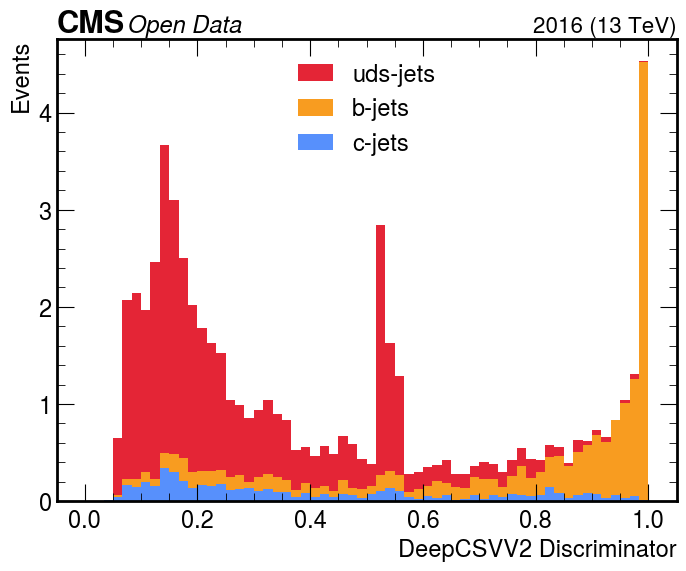

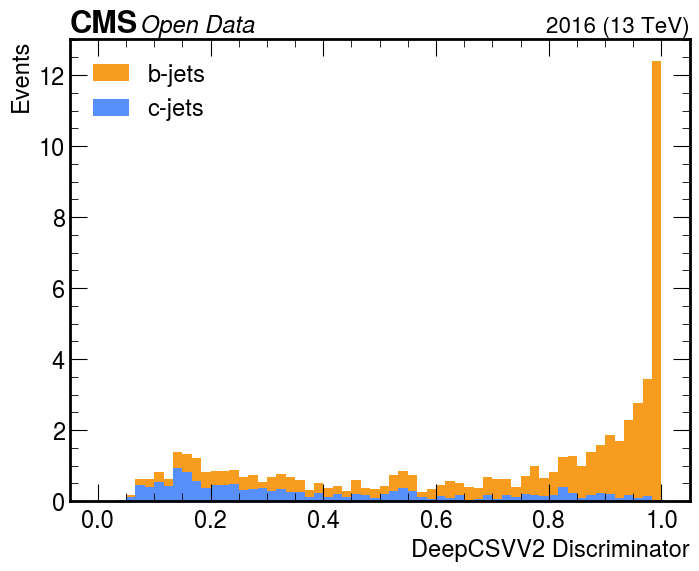

In [33]:
bjets_CSV = RecoJet_btagCSVV2[b_mask]
bjets_CSV = bjets_CSV[bjets_CSV != -1]

cjets_CSV = RecoJet_btagCSVV2[c_mask]
cjets_CSV = cjets_CSV[cjets_CSV != -1]

lightjets_CSV = RecoJet_btagCSVV2[light_mask]
lightjets_CSV = lightjets_CSV[lightjets_CSV != -1]

data = [cjets_CSV, bjets_CSV, lightjets_CSV]
labels = ["c-jets", "b-jets", "uds-jets"]

data_BvC = [cjets_CSV, bjets_CSV]
labels_BvC = ["c-jets", "b-jets"]

make_stack_hist(
    data=data,
    labels=labels,
    bins=60,
    range=(0, 1),
    xlabel="DeepCSVV2 Discriminator",
    ylabel="Events",
    fname="plots/bTagDiscDeepCSVV2.png",
    logy=False
)

make_stack_hist(
    data=data_BvC,
    labels=labels_BvC,
    bins=60,
    range=(0, 1),
    xlabel="DeepCSVV2 Discriminator",
    ylabel="Events",
    fname="plots/bTagDiscDeepCSVV2_BvC.png",
    logy=False
)

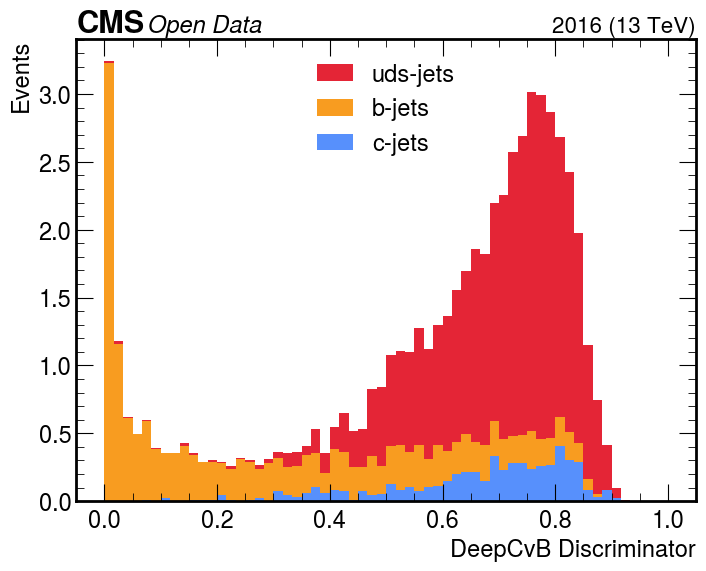

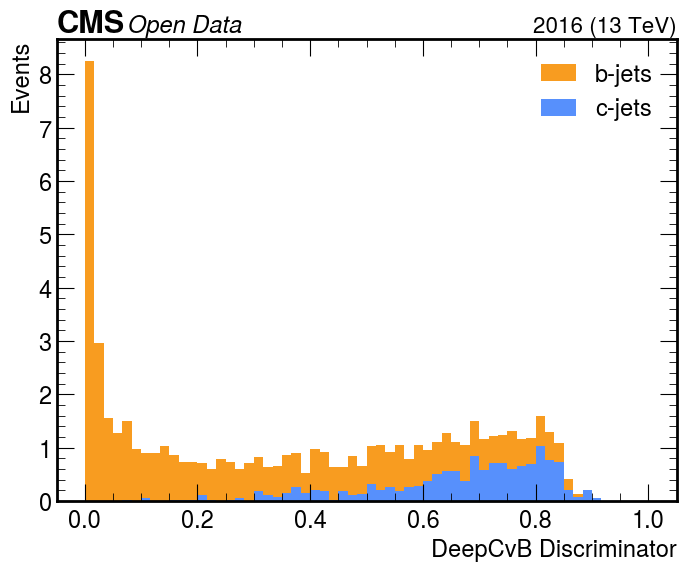

In [29]:
bjets_DeepCvB = RecoJet_btagDeepCvB[b_mask]
bjets_DeepCvB = bjets_DeepCvB[bjets_DeepCvB != -1]

cjets_DeepCvB = RecoJet_btagDeepCvB[c_mask]
cjets_DeepCvB = cjets_DeepCvB[cjets_DeepCvB != -1]

lightjets_DeepCvB = RecoJet_btagDeepCvB[light_mask]
lightjets_DeepCvB = lightjets_DeepCvB[lightjets_DeepCvB != -1]

data = [cjets_DeepCvB, bjets_DeepCvB, lightjets_DeepCvB]
labels = ["c-jets", "b-jets", "uds-jets"]

data_BvC = [cjets_DeepCvB, bjets_DeepCvB]
labels_BvC = ["c-jets", "b-jets"]

make_stack_hist(
    data=data,
    labels=labels,
    bins=60,
    range=(0, 1),
    xlabel="DeepCvB Discriminator",
    ylabel="Events",
    fname="plots/bTagDiscDeepCvB.png",
    logy=False
)

make_stack_hist(
    data=data_BvC,
    labels=labels_BvC,
    bins=60,
    range=(0, 1),
    xlabel="DeepCvB Discriminator",
    ylabel="Events",
    fname="plots/bTagDiscDeepCvB_BvC.png",
    logy=False
)

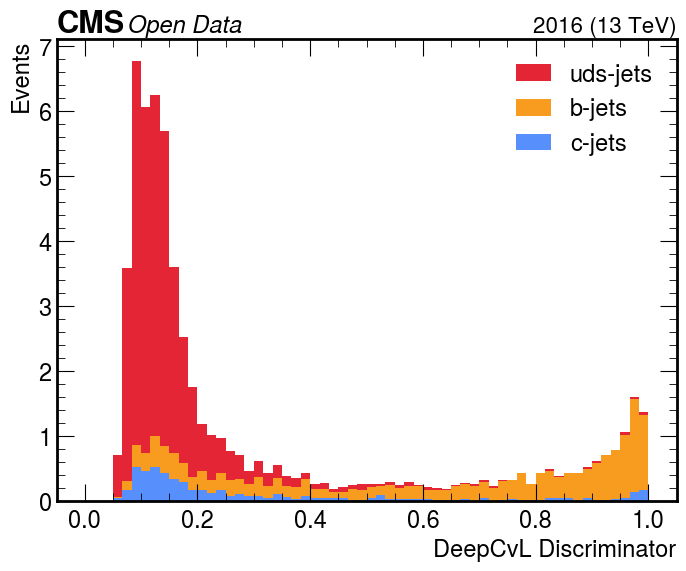

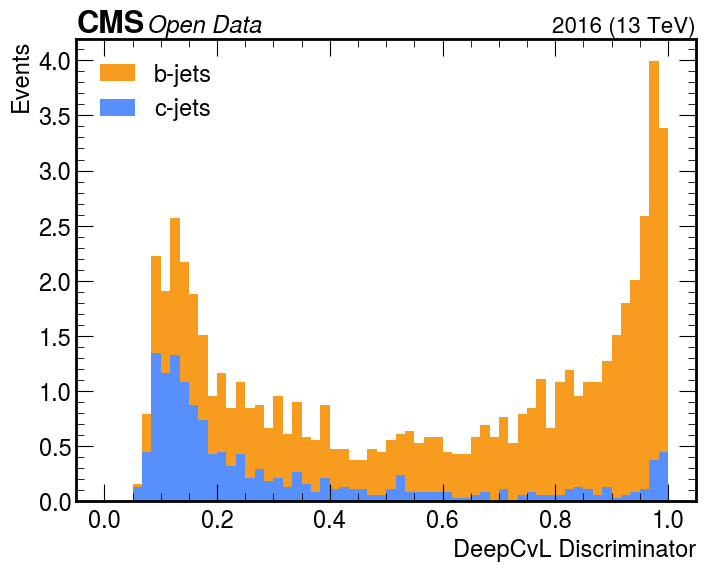

In [47]:
bjets_DeepCvL = RecoJet_btagDeepCvL[b_mask]
bjets_DeepCvL = bjets_DeepCvL[bjets_DeepCvL != -1]
cjets_DeepCvL = RecoJet_btagDeepCvL[c_mask]
cjets_DeepCvL = cjets_DeepCvL[cjets_DeepCvL != -1]
lightjets_DeepCvL = RecoJet_btagDeepCvL[light_mask]
lightjets_DeepCvL = lightjets_DeepCvL[lightjets_DeepCvL != -1]

data = [cjets_DeepCvL, bjets_DeepCvL, lightjets_DeepCvL]
labels = ["c-jets", "b-jets", "uds-jets"]

data_BvC = [cjets_DeepCvL, bjets_DeepCvL]
labels_BvC = ["c-jets", "b-jets"]

make_stack_hist(
    data=data,
    labels=labels,
    bins=60,
    range=(0, 1),
    xlabel="DeepCvL Discriminator",
    ylabel="Events",
    fname="plots/bTagDiscDeepCvL.png",
    logy=False
)
make_stack_hist(
    data=data_BvC,
    labels=labels_BvC,
    bins=60,
    range=(0, 1),
    xlabel="DeepCvL Discriminator",
    ylabel="Events",
    fname="plots/bTagDiscDeepCvL_BvC.png",
    logy=False
)

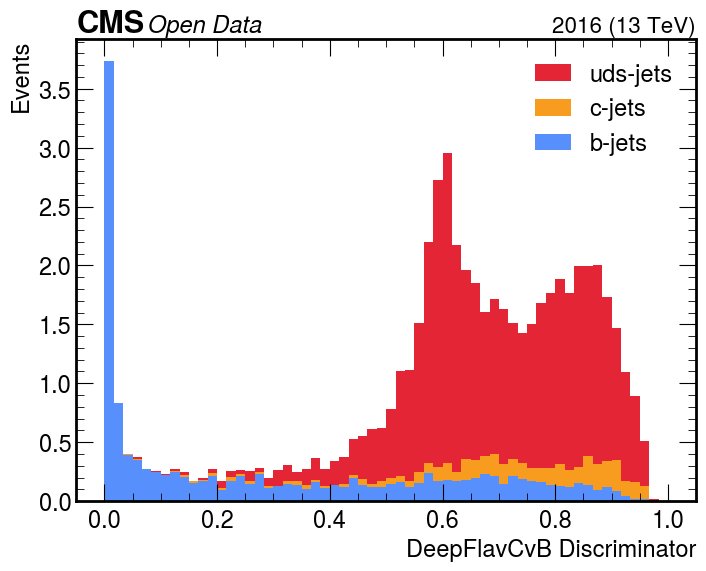

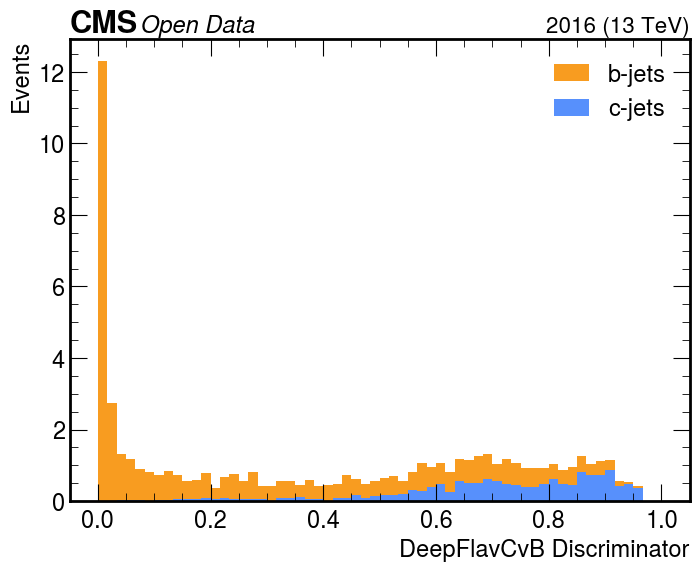

In [30]:
bjets_DeepFlavCvB = RecoJet_btagDeepFlavCvB[b_mask]
bjets_DeepFlavCvB = bjets_DeepFlavCvB[bjets_DeepFlavCvB != -1]

cjets_DeepFlavCvB = RecoJet_btagDeepFlavCvB[c_mask]
cjets_DeepFlavCvB = cjets_DeepFlavCvB[cjets_DeepFlavCvB != -1]

lightjets_DeepFlavCvB = RecoJet_btagDeepFlavCvB[light_mask]
lightjets_DeepFlavCvB = lightjets_DeepFlavCvB[lightjets_DeepFlavCvB != -1]

data = [bjets_DeepFlavCvB, cjets_DeepFlavCvB, lightjets_DeepFlavCvB]
labels = ["b-jets", "c-jets", "uds-jets"]

data_BvC = [cjets_DeepFlavCvB, bjets_DeepFlavCvB]
labels_BvC = ["c-jets", "b-jets"]

make_stack_hist(
    data=data,
    labels=labels,
    bins=60,
    range=(0, 1),
    xlabel="DeepFlavCvB Discriminator",
    ylabel="Events",
    fname="plots/bTagDiscDeepFlavCvB.png",
    logy=False
)

make_stack_hist(
    data=data_BvC,
    labels=labels_BvC,
    bins=60,
    range=(0, 1),
    xlabel="DeepFlavCvB Discriminator",
    ylabel="Events",
    fname="plots/bTagDiscDeepFlavCvB_BvC.png",
    logy=False
)

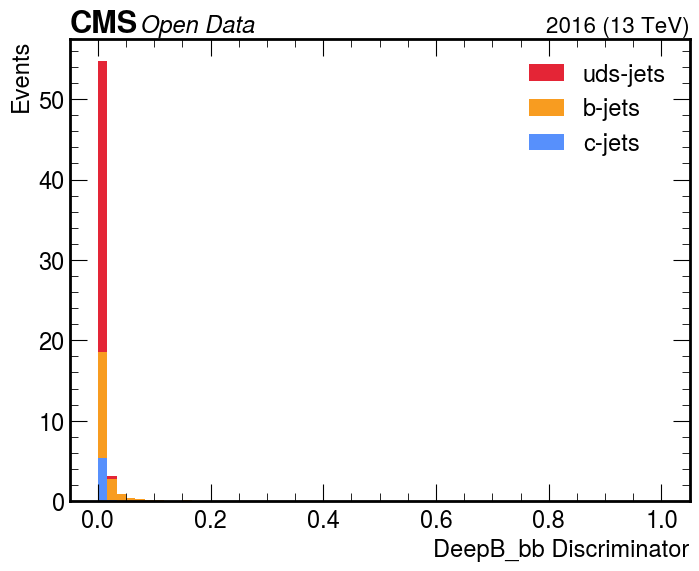

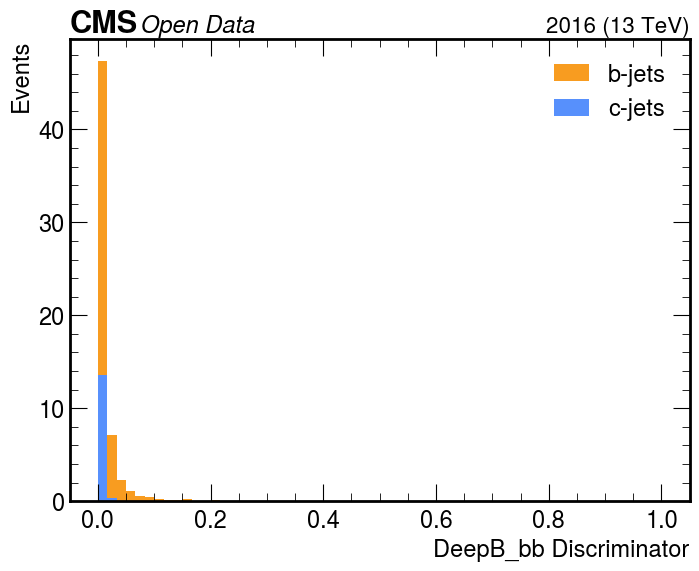

In [45]:
bjets_DeepB_bb = RecoJet_btagDeepB_bb[b_mask]
bjets_DeepB_bb = bjets_DeepB_bb[bjets_DeepB_bb != -1]

cjets_DeepB_bb = RecoJet_btagDeepB_bb[c_mask]
cjets_DeepB_bb = cjets_DeepB_bb[cjets_DeepB_bb != -1]

lightjets_DeepB_bb = RecoJet_btagDeepB_bb[light_mask]
lightjets_DeepB_bb = lightjets_DeepB_bb[lightjets_DeepB_bb != -1]

data = [cjets_DeepB_bb, bjets_DeepB_bb, lightjets_DeepB_bb]
labels = ["c-jets", "b-jets", "uds-jets"]

data_BvC = [cjets_DeepB_bb, bjets_DeepB_bb]
labels_BvC = ["c-jets", "b-jets"]

make_stack_hist(
    data=data,
    labels=labels,
    bins=60,
    range=(0, 1),
    xlabel="DeepB_bb Discriminator",
    ylabel="Events",
    fname="plots/bTagDiscDeepB_bb.png",
    logy=False
)

make_stack_hist(
    data=data_BvC,
    labels=labels_BvC,
    bins=60,
    range=(0, 1),
    xlabel="DeepB_bb Discriminator",
    ylabel="Events",
    fname="plots/bTagDiscDeepB_bb_BvC.png",
    logy=False
)

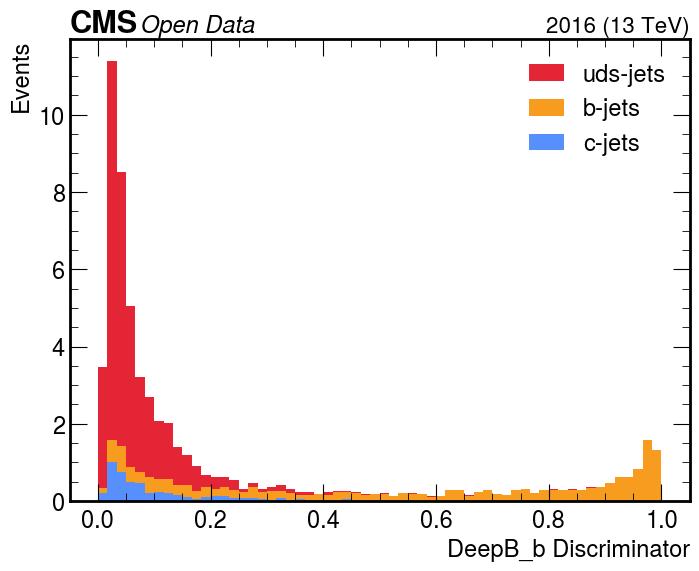

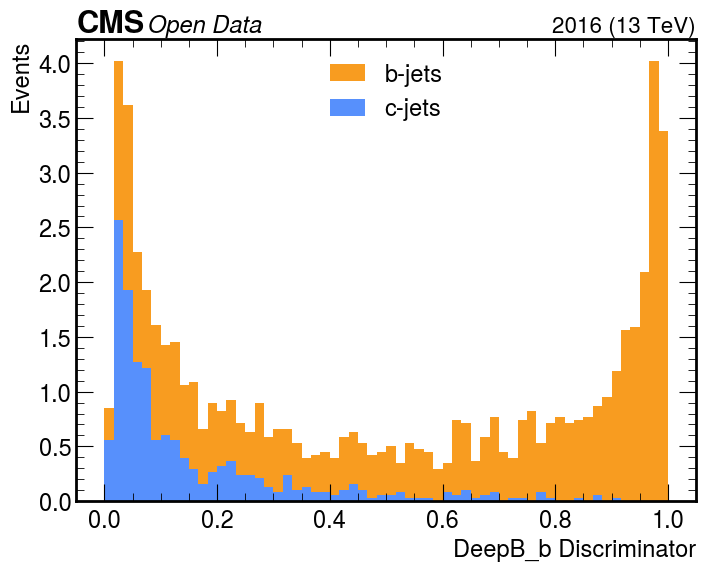

In [32]:
bjets_DeepB_b = RecoJet_btagDeepB_b[b_mask]
bjets_DeepB_b = bjets_DeepB_b[bjets_DeepB_b != -1]

cjets_DeepB_b = RecoJet_btagDeepB_b[c_mask]
cjets_DeepB_b = cjets_DeepB_b[cjets_DeepB_b != -1]

lightjets_DeepB_b = RecoJet_btagDeepB_b[light_mask]
lightjets_DeepB_b = lightjets_DeepB_b[lightjets_DeepB_b != -1]

data = [cjets_DeepB_b, bjets_DeepB_b, lightjets_DeepB_b]
labels = ["c-jets", "b-jets", "uds-jets"]

data_BvC = [cjets_DeepB_b, bjets_DeepB_b]
labels_BvC = ["c-jets", "b-jets"]

make_stack_hist(
    data=data,
    labels=labels,
    bins=60,
    range=(0, 1),
    xlabel="DeepB_b Discriminator",
    ylabel="Events",
    fname="plots/bTagDiscDeepB_b.png",
    logy=False
)

make_stack_hist(
    data=data_BvC,
    labels=labels_BvC,
    bins=60,
    range=(0, 1),
    xlabel="DeepB_b Discriminator",
    ylabel="Events",
    fname="plots/bTagDiscDeepB_b_BvC.png",
    logy=False
)

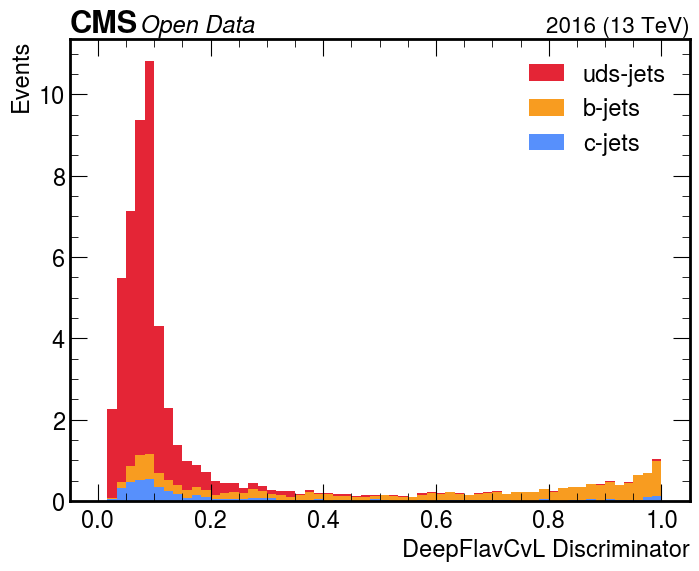

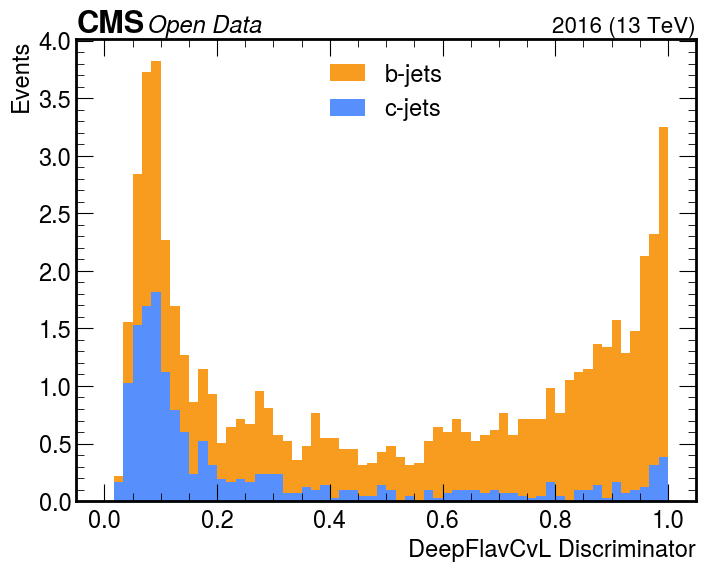

In [34]:
bjets_FlavCvL = RecoJet_btagDeepFlavCvL[b_mask]
bjets_FlavCvL = bjets_FlavCvL[bjets_FlavCvL != -1]
cjets_FlavCvL = RecoJet_btagDeepFlavCvL[c_mask]
cjets_FlavCvL = cjets_FlavCvL[cjets_FlavCvL != -1]
lightjets_FlavCvL = RecoJet_btagDeepFlavCvL[light_mask]
lightjets_FlavCvL = lightjets_FlavCvL[lightjets_FlavCvL != -1]

data = [cjets_FlavCvL, bjets_FlavCvL, lightjets_FlavCvL]
labels = ["c-jets", "b-jets", "uds-jets"]

data_BvC = [cjets_FlavCvL, bjets_FlavCvL]
labels_BvC = ["c-jets", "b-jets"]

make_stack_hist(
    data=data,
    labels=labels,
    bins=60,
    range=(0, 1),
    xlabel="DeepFlavCvL Discriminator",
    ylabel="Events",
    fname="plots/bTagDiscDeepFlavCvL.png",
    logy=False
)

make_stack_hist(
    data=data_BvC,
    labels=labels_BvC,
    bins=60,
    range=(0, 1),
    xlabel="DeepFlavCvL Discriminator",
    ylabel="Events",
    fname="plots/bTagDiscDeepFlavCvL_BvC.png",
    logy=False
)

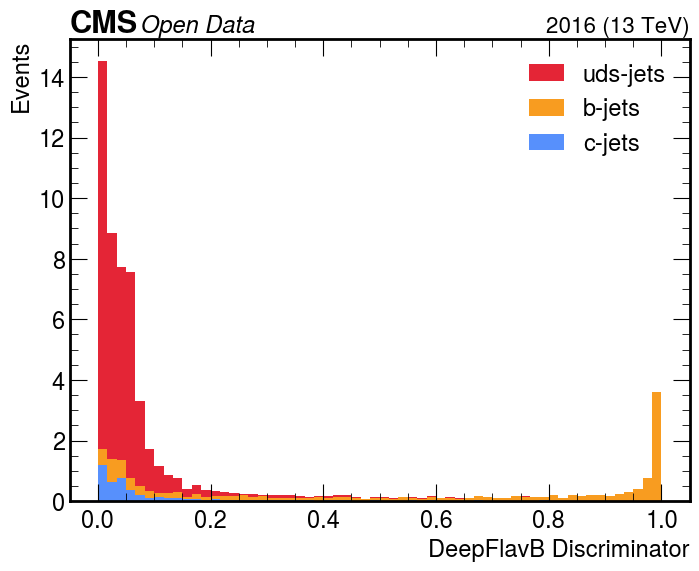

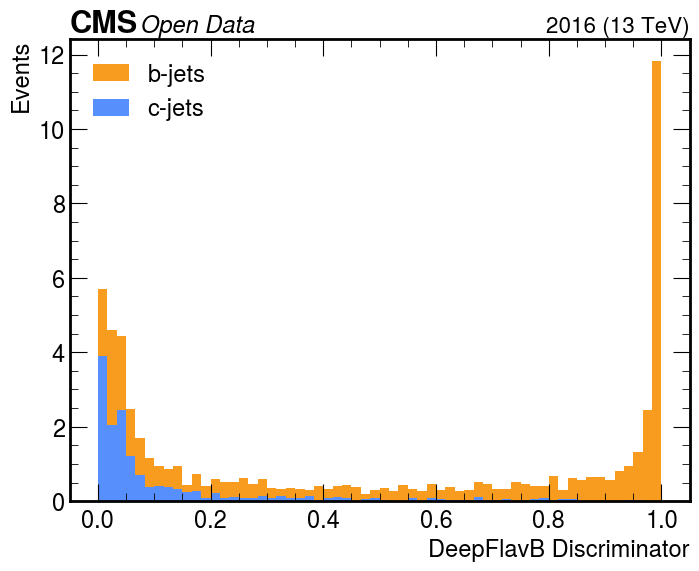

In [35]:
bjets_DeepFlavB = RecoJet_btagDeepFlavB[b_mask]
bjets_DeepFlavB = bjets_DeepFlavB[bjets_DeepFlavB != -1]
cjets_DeepFlavB = RecoJet_btagDeepFlavB[c_mask]
cjets_DeepFlavB = cjets_DeepFlavB[cjets_DeepFlavB != -1]
lightjets_DeepFlavB = RecoJet_btagDeepFlavB[light_mask]
lightjets_DeepFlavB = lightjets_DeepFlavB[lightjets_DeepFlavB != -1]

data = [cjets_DeepFlavB, bjets_DeepFlavB, lightjets_DeepFlavB]
labels = ["c-jets", "b-jets", "uds-jets"]

data_BvC = [cjets_DeepFlavB, bjets_DeepFlavB]
labels_BvC = ["c-jets", "b-jets"]

make_stack_hist(
    data=data,
    labels=labels,
    bins=60,
    range=(0, 1),
    xlabel="DeepFlavB Discriminator",
    ylabel="Events",
    fname="plots/bTagDiscDeepFlavB.png",
    logy=False
)

make_stack_hist(
    data=data_BvC,
    labels=labels_BvC,
    bins=60,
    range=(0, 1),
    xlabel="DeepFlavB Discriminator",
    ylabel="Events",
    fname="plots/bTagDiscDeepFlavB_BvC.png",
    logy=False
)

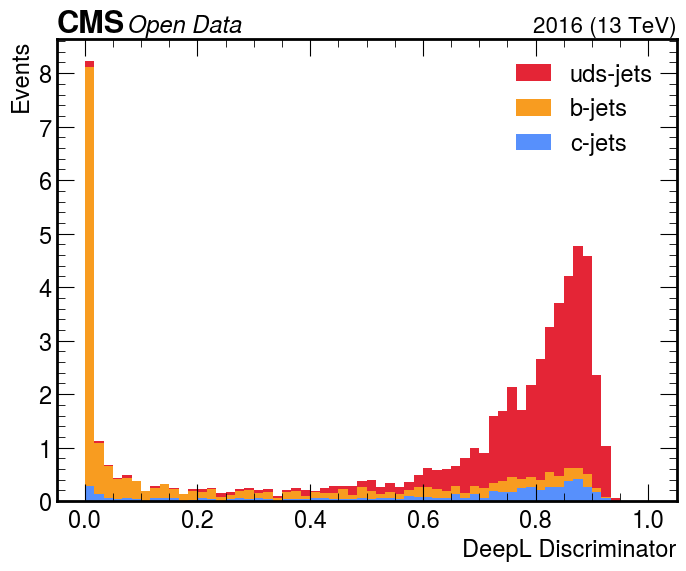

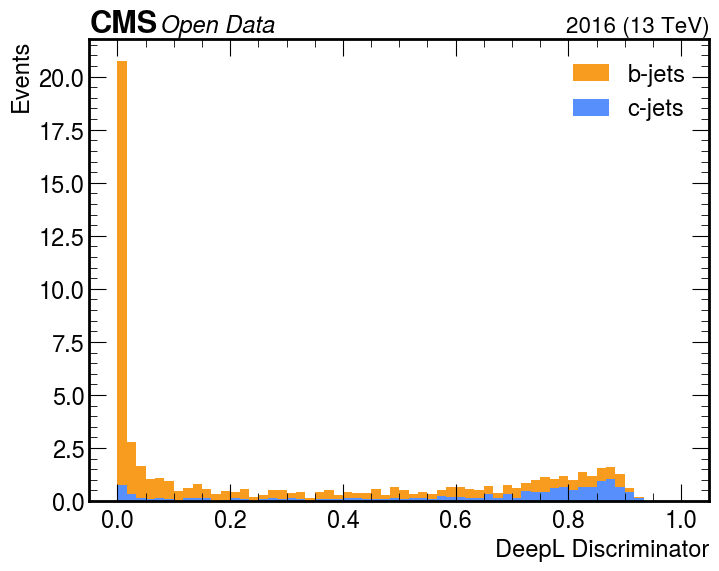

In [44]:
bjets_DeepL = RecoJet_btagDeepL[b_mask]
bjets_DeepL = bjets_DeepL[bjets_DeepL != -1]
cjets_DeepL = RecoJet_btagDeepL[c_mask]
cjets_DeepL = cjets_DeepL[cjets_DeepL != -1]
lightjets_DeepL = RecoJet_btagDeepL[light_mask]
lightjets_DeepL = lightjets_DeepL[lightjets_DeepL != -1]

data = [cjets_DeepL, bjets_DeepL, lightjets_DeepL]
labels = ["c-jets", "b-jets", "uds-jets"]
data_BvC = [cjets_DeepL, bjets_DeepL]
labels_BvC = ["c-jets", "b-jets"]

make_stack_hist(
    data=data,
    labels=labels,
    bins=60,
    range=(0, 1),
    xlabel="DeepL Discriminator",
    ylabel="Events",
    fname="plots/bTagDiscDeepL.png",
    logy=False
)
make_stack_hist(
    data=data_BvC,
    labels=labels_BvC,
    bins=60,
    range=(0, 1),
    xlabel="DeepL Discriminator",
    ylabel="Events",
    fname="plots/bTagDiscDeepL_BvC.png",
    logy=False
)

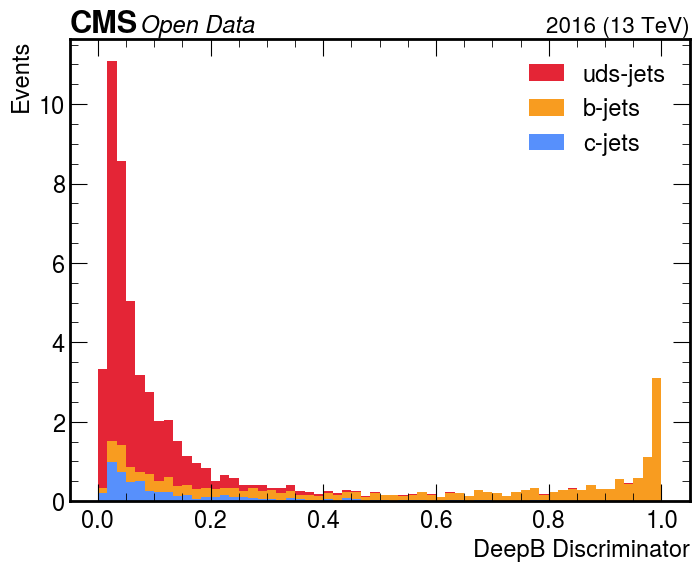

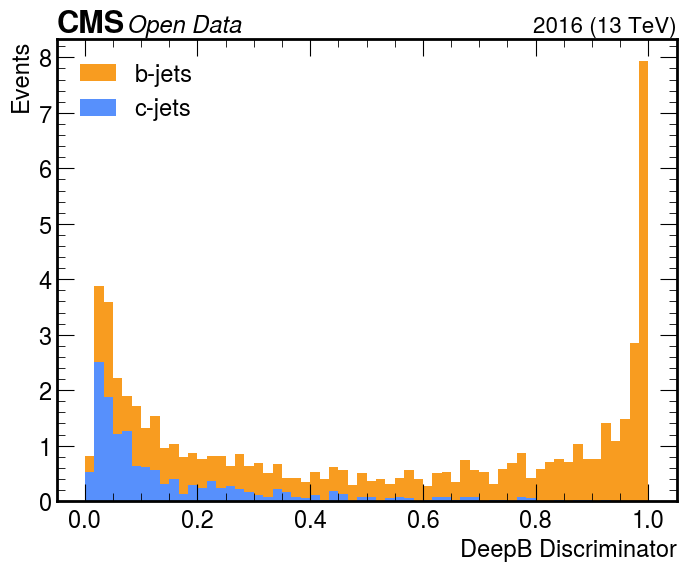

In [46]:
bjets_DeepB = RecoJet_btagDeepB[b_mask]
bjets_DeepB = bjets_DeepB[bjets_DeepB != -1]
cjets_DeepB = RecoJet_btagDeepB[c_mask]
cjets_DeepB = cjets_DeepB[cjets_DeepB != -1]
lightjets_DeepB = RecoJet_btagDeepB[light_mask]
lightjets_DeepB = lightjets_DeepB[lightjets_DeepB != -1]

data = [cjets_DeepB, bjets_DeepB, lightjets_DeepB]
labels = ["c-jets", "b-jets", "uds-jets"]

data_BvC = [cjets_DeepB, bjets_DeepB]
labels_BvC = ["c-jets", "b-jets"]

make_stack_hist(
    data=data,
    labels=labels,
    bins=60,
    range=(0, 1),
    xlabel="DeepB Discriminator",
    ylabel="Events",
    fname="plots/bTagDiscDeepB.png",
    logy=False
)
make_stack_hist(
    data=data_BvC,
    labels=labels_BvC,
    bins=60,
    range=(0, 1),
    xlabel="DeepB Discriminator",
    ylabel="Events",
    fname="plots/bTagDiscDeepB_BvC.png",
    logy=False
)

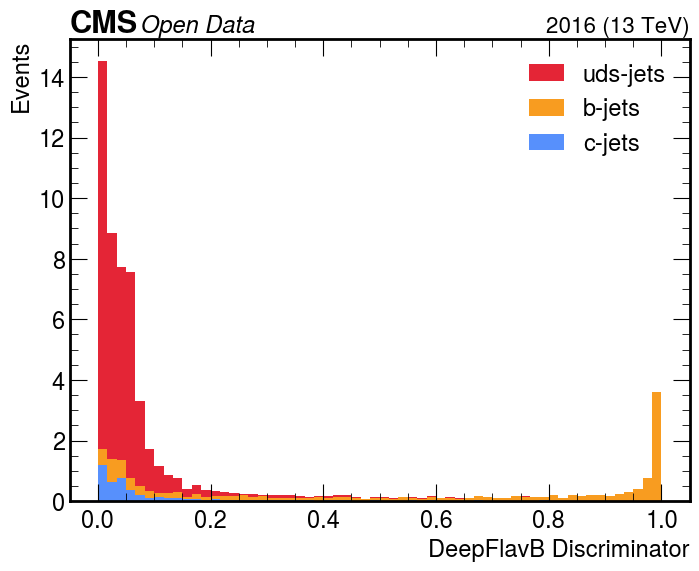

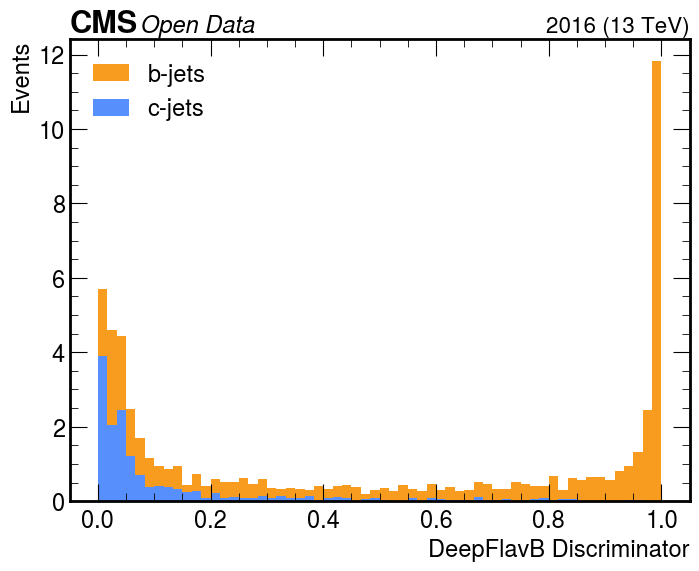

In [48]:
bjets_DeepFlavB = RecoJet_btagDeepFlavB[b_mask]
bjets_DeepFlavB = bjets_DeepFlavB[bjets_DeepFlavB != -1]
cjets_DeepFlavB = RecoJet_btagDeepFlavB[c_mask]
cjets_DeepFlavB = cjets_DeepFlavB[cjets_DeepFlavB != -1]
lightjets_DeepFlavB = RecoJet_btagDeepFlavB[light_mask]
lightjets_DeepFlavB = lightjets_DeepFlavB[lightjets_DeepFlavB != -1]

data = [cjets_DeepFlavB, bjets_DeepFlavB, lightjets_DeepFlavB]
labels = ["c-jets", "b-jets", "uds-jets"]

data_BvC = [cjets_DeepFlavB, bjets_DeepFlavB]
labels_BvC = ["c-jets", "b-jets"]

make_stack_hist(
    data=data,
    labels=labels,
    bins=60,
    range=(0, 1),
    xlabel="DeepFlavB Discriminator",
    ylabel="Events",
    fname="plots/bTagDiscDeepFlavB.png",
    logy=False
)
make_stack_hist(
    data=data_BvC,
    labels=labels_BvC,
    bins=60,
    range=(0, 1),
    xlabel="DeepFlavB Discriminator",
    ylabel="Events",
    fname="plots/bTagDiscDeepFlavB_BvC.png",
    logy=False
)

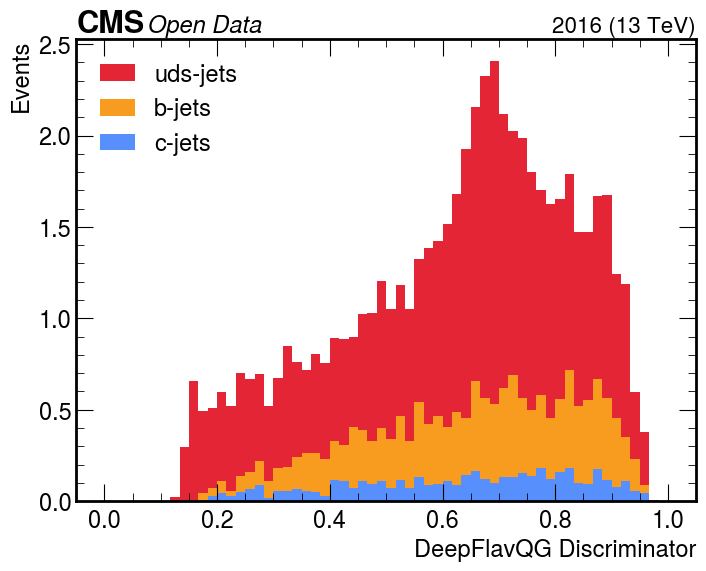

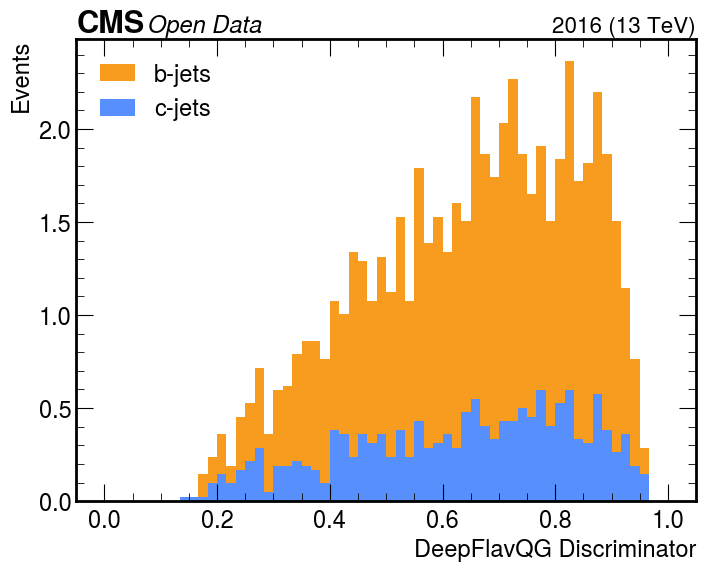

In [49]:
bjets_DeepFlavQG = RecoJet_btagDeepFlavQG[b_mask]
bjets_DeepFlavQG = bjets_DeepFlavQG[bjets_DeepFlavQG != -1]
cjets_DeepFlavQG = RecoJet_btagDeepFlavQG[c_mask]
cjets_DeepFlavQG = cjets_DeepFlavQG[cjets_DeepFlavQG != -1]
lightjets_DeepFlavQG = RecoJet_btagDeepFlavQG[light_mask]
lightjets_DeepFlavQG = lightjets_DeepFlavQG[lightjets_DeepFlavQG != -1]

data = [cjets_DeepFlavQG, bjets_DeepFlavQG, lightjets_DeepFlavQG]
labels = ["c-jets", "b-jets", "uds-jets"]

data_BvC = [cjets_DeepFlavQG, bjets_DeepFlavQG]
labels_BvC = ["c-jets", "b-jets"]

make_stack_hist(
    data=data,
    labels=labels,
    bins=60,
    range=(0, 1),
    xlabel="DeepFlavQG Discriminator",
    ylabel="Events",
    fname="plots/bTagDiscDeepFlavQG.png",
    logy=False
)
make_stack_hist(
    data=data_BvC,
    labels=labels_BvC,
    bins=60,
    range=(0, 1),
    xlabel="DeepFlavQG Discriminator",
    ylabel="Events",
    fname="plots/bTagDiscDeepFlavQG_BvC.png",
    logy=False
)